In [4]:
# Packages
import torch
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchmetrics.functional import r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings

# my model
from model.LSTM import L_LSTM_MSE as LSTM

In [2]:
# model setting
model = LSTM(input_size=14, hidden_size=20, num_layers=2, output_size=2)
torch.manual_seed = 81
epochs = 50
batch_size = 32
log_every_n_step = 10

In [6]:
# dataset
warnings.filterwarnings('ignore')
directory = "data\pollution\AirPollution.csv"  # can use url
df = pd.read_csv(directory, delimiter=",")
print(df.head())

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


In [7]:
warnings.filterwarnings('ignore')
# remove NA data
df = df.dropna()  # remove any row that contains NAN
print(f"{df.shape[0]} rows left after removing NA")  # 41757 rows left

# drop number column, add pm2.5 and temp as label
df = df.drop(["No"], axis=1)
df[["pm2.5_label", "TEMP_label"]] = df[["pm2.5", "TEMP"]].shift(periods=-1)
# create labels by shifting 1 row up

# normalization with MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:, np.r_[0:8, 9:14]] = scaler.fit_transform(df.iloc[:, np.r_[0:8, 9:14]])
# normalize columns except 'cbwd'
# columns with dtype int64 gives warning when normalized

# encode category data
df = pd.get_dummies(df, columns=["cbwd"], dtype=int, drop_first=True)
# create dummy columns for 'cbwd'
df.insert(8, "cbwd_NW", df.pop("cbwd_NW"))  # relocate dummy columns
df.insert(9, "cbwd_SE", df.pop("cbwd_SE"))
df.insert(10, "cbwd_cv", df.pop("cbwd_cv"))
print(df.head())

# assign the last 57 row for prediction
prediction = df.tail(57)
df.drop(df.tail(57).index, inplace=True)

41757 rows left after removing NA
    year  month       day      hour     pm2.5      DEWP      TEMP      PRES  \
24   0.0    0.0  0.033333  0.000000  0.129779  0.352941  0.245902  0.527273   
25   0.0    0.0  0.033333  0.043478  0.148893  0.367647  0.245902  0.527273   
26   0.0    0.0  0.033333  0.086957  0.159960  0.426471  0.229508  0.545455   
27   0.0    0.0  0.033333  0.130435  0.182093  0.485294  0.229508  0.563636   
28   0.0    0.0  0.033333  0.173913  0.138833  0.485294  0.229508  0.563636   

    cbwd_NW  cbwd_SE  cbwd_cv       Iws        Is   Ir  pm2.5_label  \
24        0        1        0  0.002372  0.000000  0.0     0.148893   
25        0        1        0  0.003947  0.000000  0.0     0.159960   
26        0        1        0  0.005522  0.000000  0.0     0.182093   
27        0        1        0  0.008690  0.037037  0.0     0.138833   
28        0        1        0  0.010265  0.074074  0.0     0.109658   

    TEMP_label  
24    0.245902  
25    0.229508  
26    0.22950

In [8]:
# separate inputs and labels
X = df.drop(
    ["pm2.5_label", "TEMP_label"], axis=1
)  # axis=1 =remove column, axis=0 = remove 1st row/index
y = df[["pm2.5_label", "TEMP_label"]]
# assigning inputs and labels and convert to tensor
input = torch.FloatTensor(X.values)
label = torch.FloatTensor(y.values)

# train test split
train_input, test_input, train_label, test_label = train_test_split(
    input,
    label,
    test_size=0.1,
    shuffle=False,  # no shuffle for time series
    random_state=81,
)
train_dataset = TensorDataset(train_input, train_label)
test_dataset = TensorDataset(test_input, test_label)
# dataloader
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size)
# no shuffle bc time series data
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [9]:
# training
trainer = L.Trainer(max_epochs=epochs, log_every_n_steps=log_every_n_step)
# learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    min_lr=0.001,
    max_lr=1.0,
    early_stop_threshold=None,
)
new_lr = lr_find_results.suggestion()
model.learning_rate = new_lr
print(f"lr_find() suggest {new_lr:5f} for the learning rate.")
# train to fit
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 94.09it/s]
Learning rate set to 0.003019951720402016
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\.lr_find_b56c094a-6b13-43c3-b720-61d0ce4682c6.ckpt
Restored all states from the checkpoint at d:\Work repository\NN_test_build\.lr_find_b56c094a-6b13-43c3-b720-61d0ce4682c6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
-------------

lr_find() suggest 0.003020 for the learning rate.
Epoch 49: 100%|██████████| 1173/1173 [00:06<00:00, 189.78it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1173/1173 [00:06<00:00, 189.66it/s, v_num=6]


In [11]:
# monitor loss by tensorboard
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 3108), started 0:00:56 ago. (Use '!kill 3108' to kill it.)

train loss settled at 0.0002

In [12]:
# testing
best_ckpt = trainer.checkpoint_callback.best_model_path
trainer.test(model, dataloaders=test_loader, ckpt_path=best_ckpt)

Restoring states from the checkpoint path at d:\Work repository\NN_test_build\lightning_logs\version_6\checkpoints\epoch=49-step=58650.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at d:\Work repository\NN_test_build\lightning_logs\version_6\checkpoints\epoch=49-step=58650.ckpt


Testing DataLoader 0: 100%|██████████| 131/131 [00:00<00:00, 417.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0005924187717027962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0005924187717027962}]

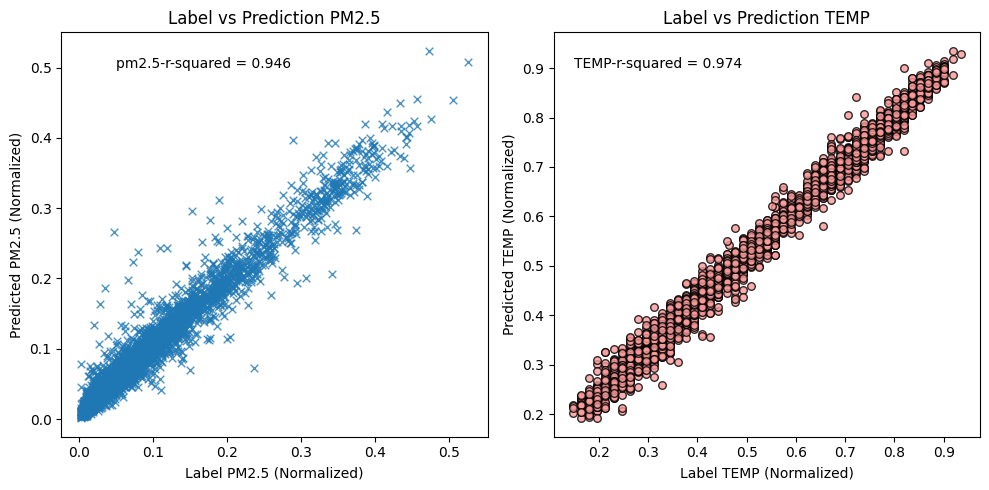

In [14]:
# r2-score and plot
test_res = model.forward(test_input).detach()

plt.figure(figsize=(10, 5))
plt.style.use("seaborn-v0_8-colorblind")
plt.subplot(1, 2, 1)
plt.scatter(
    test_label[:, 0],
    test_res[:, 0],
    marker="x",  # marker shape
    s=30,  # marker size
    c="#1f78b4",  # marker color hex code (blue)
    # edgecolors="black",  # axis color (not for unfilled marker)
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction PM2.5")
plt.xlabel("Label PM2.5 (Normalized)")
plt.ylabel("Predicted PM2.5 (Normalized)")
plt.annotate(
    "pm2.5-r-squared = {:.3f}".format(r2_score(test_label[:, 0], test_res[:, 0])),
    (0.05, 0.5),
)
# (0,1) argument are x and y coordinate on the graph

plt.subplot(1, 2, 2)
plt.scatter(
    test_label[:, 1],
    test_res[:, 1],
    marker="o",  # marker shape
    s=30,  # marker size
    c="#fb9a99",  # marker color hex code (grapefruit)
    edgecolors="black",  # axis color
    linewidths=1,  # axis width
    alpha=0.80,  # axis alpha
)
plt.title("Label vs Prediction TEMP")
plt.xlabel("Label TEMP (Normalized)")
plt.ylabel("Predicted TEMP (Normalized)")
plt.annotate(
    "TEMP-r-squared = {:.3f}".format(r2_score(test_label[:, 1], test_res[:, 1])),
    (0.15, 0.9),
)
# (0,1) argument are x and y coordinate on the graph

plt.tight_layout()
plt.show()

In [15]:
# save parameters
torch.save(model.state_dict(), "trained_parameters\l_LSTM_airpollusion.pt")

In [17]:
# prediction
loaded_model = LSTM(input_size=14, hidden_size=20, num_layers=2, output_size=2)
loaded_model.load_state_dict(torch.load("trained_parameters\l_LSTM_airpollusion.pt"))

X_real = prediction.drop(["pm2.5_label", "TEMP_label"], axis=1)
input_real = torch.FloatTensor(X_real.values)

output_real = loaded_model.forward(input_real).detach()
X_real["pm2.5_pred"] = output_real[:, 0]
X_real["TEMP_pred"] = output_real[:, 1]

cbwd = pd.from_dummies(X_real[['cbwd_NW', 'cbwd_SE', 'cbwd_cv']], sep="_", default_category="NE")
# reverse dummy columns
df_pred = X_real.drop(['cbwd_NW', 'cbwd_SE', 'cbwd_cv'], axis=1)
df_pred.insert(8, 'cbwd', cbwd)
df_pred.iloc[:, np.r_[0:8, 9:14]] = scaler.inverse_transform(df_pred.iloc[:, np.r_[0:8, 9:14]])
# inverse scaler
print(df_pred)

         year  month   day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws   Is  \
43767  2014.0   12.0  29.0  15.0   28.0 -14.0  11.0  1011.0   NW   25.48  0.0   
43768  2014.0   12.0  29.0  16.0   20.0 -15.0  11.0  1011.0   NW   32.63  0.0   
43769  2014.0   12.0  29.0  17.0   22.0 -15.0  10.0  1012.0   NW   36.65  0.0   
43770  2014.0   12.0  29.0  18.0  120.0 -15.0   6.0  1013.0   cv    0.89  0.0   
43771  2014.0   12.0  29.0  19.0  109.0 -14.0   3.0  1013.0   cv    1.78  0.0   
43772  2014.0   12.0  29.0  20.0  112.0 -12.0   1.0  1014.0   cv    2.67  0.0   
43773  2014.0   12.0  29.0  21.0  128.0 -13.0   0.0  1015.0   cv    3.12  0.0   
43774  2014.0   12.0  29.0  22.0  164.0 -12.0  -3.0  1015.0   NE    3.13  0.0   
43775  2014.0   12.0  29.0  23.0  159.0 -12.0  -3.0  1016.0   NW    1.79  0.0   
43776  2014.0   12.0  30.0   0.0  189.0 -12.0  -2.0  1016.0   cv    0.89  0.0   
43777  2014.0   12.0  30.0   1.0   97.0 -13.0  -2.0  1016.0   NW    1.79  0.0   
43778  2014.0   12.0  30.0  

In [20]:
df_pred.to_csv('predicted_pollusion.csv', index=False)